In [2]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
def penn_to_wn(tag):
    """
        Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [21]:
def get_sentiment_score(text):
    """
        This method returns the sentiment score of a given text using SentiWordNet sentiment scores.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """    
    total_score = 0
    raw_sentences = sent_tokenize(text)

    for sentence in raw_sentences:
        sent_score = 0
        sentence = str(sentence)
        sentence = sentence.replace("<br />", " ").translate(str.maketrans('', '', punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wn_tag = penn_to_wn(tag)
            if not wn_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()
        
        total_score = total_score + (sent_score / len(tokens))

    return (total_score / len(raw_sentences))*100

In [22]:
reviews = pd.read_csv('../data/small_corpus.csv')

In [23]:
reviews.shape

(4500, 12)

In [24]:
# drop all rows with empty reviewText
reviews.dropna(subset=['reviewText'], inplace=True)

In [25]:
reviews.shape

(4500, 12)

Means we had no data where reviewText was empty.

In [26]:
reviews['swn_score'] = reviews['reviewText'].apply(lambda text : get_sentiment_score(text))

In [27]:
reviews[['reviewText','swn_score']].sample(2)

,reviewText,swn_score
3005,Fun,37.5
3812,Excelent game!,0.0


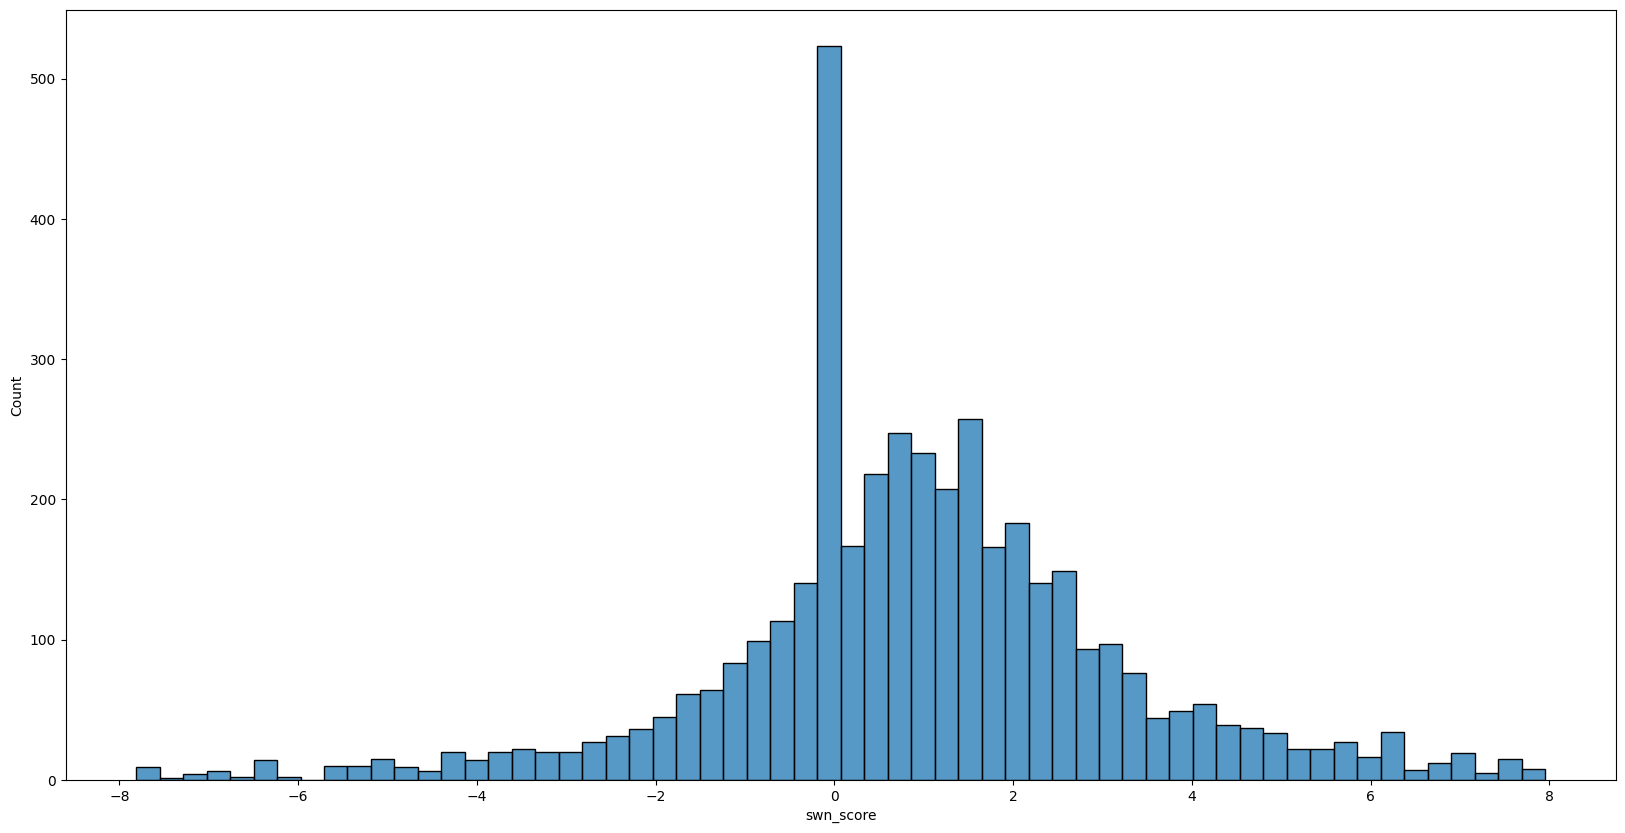

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='swn_score', data = reviews.query("swn_score <8 and swn_score > -8"), ax=ax)
plt.show()

In [29]:
reviews['swn_sentiment'] = reviews['swn_score'].apply(lambda x: "positive" if x>1 else ("negative" if x<0.5 else "neutral"))


In [30]:
reviews['swn_sentiment'].value_counts(dropna=False)

positive    2234
negative    1822
neutral      444
Name: swn_sentiment, dtype: int64

<AxesSubplot: xlabel='overall', ylabel='count'>

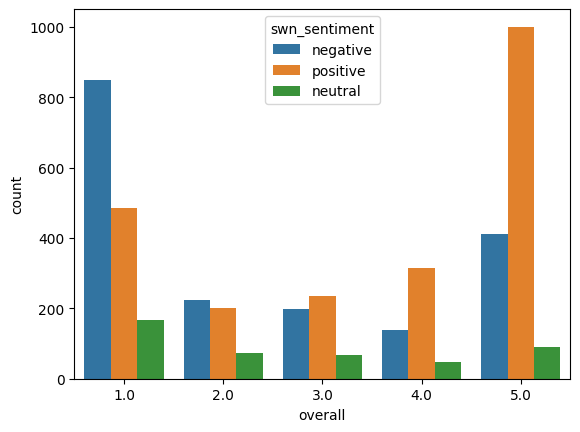

In [31]:
sns.countplot(x='overall', hue='swn_sentiment' ,data = reviews)

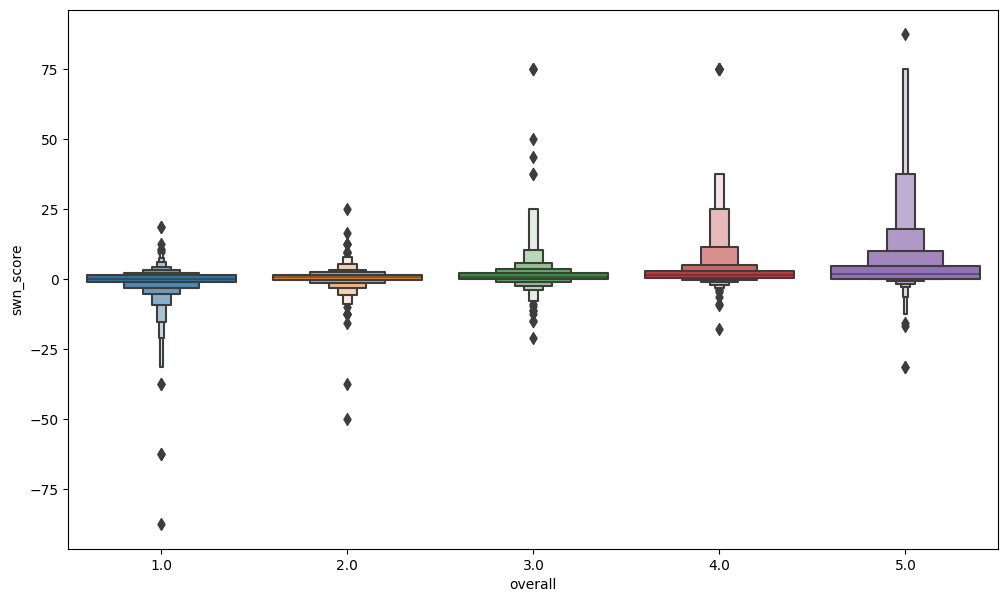

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,7))
sns.boxenplot(x='overall', y='swn_score', data = reviews, ax=ax)
plt.show()

In [33]:
reviews['true_sentiment'] = reviews['overall'].apply(lambda x: "positive" if x>=4 else ("neutral" if x==3 else "negative"))

In [34]:
y_swn_pred, y_true = reviews['swn_sentiment'].tolist(), reviews['true_sentiment'].tolist()

In [35]:
len(y_swn_pred), len(y_true)

(4500, 4500)

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_swn_pred)

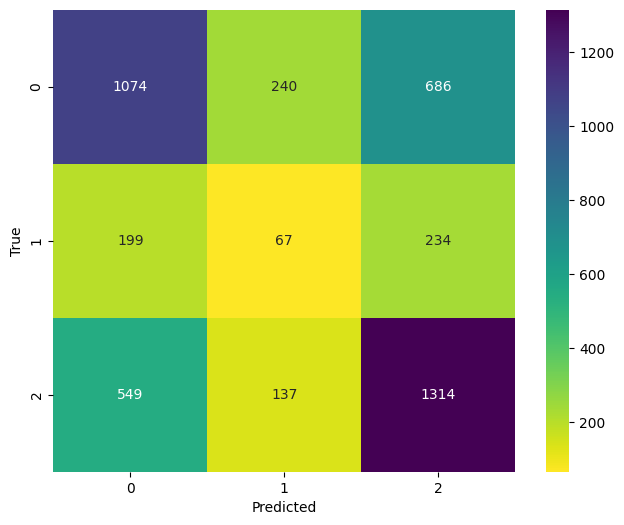

In [37]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

Negitive Sentiment Analysis

In [38]:
tp, tn, fp, fn = 1074, 67+234+137+1314, 240+686, 199+549

In [39]:
recall = tp / (tp+fn)
specifity = tn / (tn+fp)
precision = tp/(tp+fp)
f1 = (2*tp) / (2*tp + fp + fn)

In [40]:
print("recall: {}\nprecission: {}\nf1 score: {}".format(recall, precision, f1))

recall: 0.5894621295279913
precission: 0.537
f1 score: 0.5620094191522763


Positive Sentiment Analysis

In [41]:
tp, tn, fp, fn = 1314, 67+199+240+1074, 686+234, 137+549

In [42]:
recall = tp / (tp+fn)
specifity = tn / (tn+fp)
precision = tp/(tp+fp)
f1 = (2*tp) / (2*tp + fp + fn)
print("recall: {}\nprecission: {}\nf1 score: {}".format(recall, precision, f1))

recall: 0.657
precission: 0.5881826320501343
f1 score: 0.6206896551724138
